In [1]:
import pandas as pd
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, log_loss
import requests as rq
import numpy as np
import pandas_ta as ta
import plotly.graph_objects as go
from plotly._subplots import make_subplots
from datetime import datetime

In [2]:
df = pd.read_excel('EURUSD240.xlsx')
df=df[df[' Volume']!=0]
df.reset_index(drop=True, inplace=True)
df.isna().sum()


       Time    0
 Open          0
 High          0
 Low           0
 Close         0
 Volume        0
dtype: int64

In [3]:
df['Rsi'] = ta.momentum.rsi(df[' Close'],length=14)

In [4]:
df['       Time'] = pd.to_datetime(df['       Time'])

In [5]:
dfpl = df[0:100]
fig = make_subplots(rows=2, cols=1)

fig.append_trace(go.Candlestick(x=dfpl.index,
                  open=dfpl[' Open'],
                  high=dfpl[' High'],
                  low=dfpl[' Low'],
                  close=dfpl[' Close']),row=1,col=1)
fig.append_trace(go.Scatter(x=dfpl.index,
                  y=dfpl['Rsi']), row=2, col=1)

fig.update_layout(xaxis_rangeslider_visible=False)
fig.show()

Matplotlib is building the font cache; this may take a moment.


<AxesSubplot: >

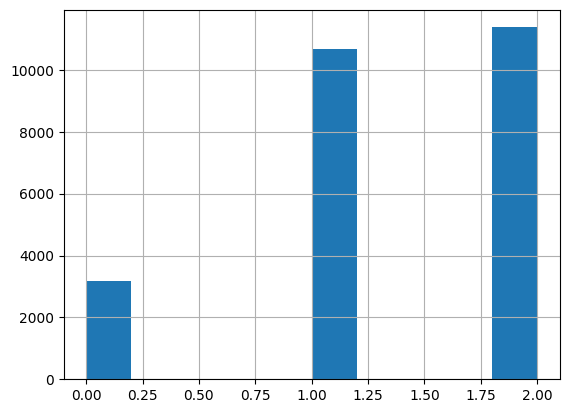

In [6]:
pipdiff = 100*1e-4
stplRatio = 1

def Target(barsupfront, df1):
    length = len(df1)
    high = list(df1[' High'])
    low = list(df1[' Low'])
    close = list(df1[' Close']) 
    open = list(df1[' Open'])
    trend = [None] * length
    for line in range (0,length-barsupfront-2):
        valueOpenLow = 0
        valueOpenHigh = 0
        for i in range (1,barsupfront+2):
            value1 = open[line+1]-low[line+i]
            value2 = open[line+1]-high[line+i]
            valueOpenLow = max(value1, valueOpenLow)
            valueOpenHigh = min(value2, valueOpenHigh)
            if ((valueOpenLow >= pipdiff ) and (-valueOpenHigh <= (pipdiff / stplRatio))):
                trend[line] = 1
                break
            elif ((valueOpenLow <= (pipdiff / stplRatio)) and (-valueOpenHigh >= pipdiff)):
                trend[line] = 2
                break
            else:
                trend[line] = 0
                
    return trend
    
df['Target'] = Target(40,df)
df['Target'].hist()

In [7]:
df.dropna(inplace=True)
df.reset_index(drop=True,inplace=True)
print(df.describe())

               Open          High           Low         Close        Volume  \
count  25198.000000  25198.000000  25198.000000  25198.000000  2.519800e+04   
mean       1.245722      1.247758      1.243726      1.245719  5.554833e+04   
std        0.135562      0.135916      0.135171      0.135563  7.027816e+04   
min        0.955040      0.957640      0.953570      0.955050  4.970000e+02   
25%        1.126810      1.128420      1.125380      1.126812  1.685025e+04   
50%        1.230710      1.232900      1.228790      1.230710  3.470350e+04   
75%        1.352657      1.354430      1.350747      1.352618  6.178850e+04   
max        1.599200      1.603890      1.596700      1.599040  2.545577e+06   

                Rsi        Target  
count  25198.000000  25198.000000  
mean      49.819971      1.325700  
std       12.983333      0.686184  
min       10.803056      0.000000  
25%       40.373596      1.000000  
50%       49.990791      1.000000  
75%       59.278428      2.000000  


In [8]:
def generate_signals(df):
  # Calculate the moving average of the closing price
  ma = df[' Close'].rolling(window=10).mean()

  # Calculate the standard deviation of the closing price
  std = df[' Close'].rolling(window=10).std()

  # Create a new column for the upper and lower bounds of the Bollinger Band
  df['bb_upper'] = ma + 2*std
  df['bb_lower'] = ma - 2*std

  # Create a signal column that is 1 when the closing price is above the upper Bollinger Band and -1 when it is below the lower Bollinger Band
  df['Signal'] = np.where(df[' Close'] > df['bb_upper'], 1, np.where(df[' Close'] < df['bb_lower'], -1, 0))



# Generate the signals
generate_signals(df)
df


,Time,Open,High,Low,Close,Volume,Rsi,Target,bb_upper,bb_lower,Signal
0,2007-01-03 04:00:00,1.32856,1.32856,1.32659,1.32723,185677,71.367025,1.0,NaN,NaN,0
1,2007-01-03 08:00:00,1.32710,1.32736,1.32170,1.32301,186690,50.551053,1.0,NaN,NaN,0
2,2007-01-03 12:00:00,1.32338,1.32571,1.31596,1.31659,577315,34.205432,1.0,NaN,NaN,0
3,2007-01-03 16:00:00,1.31672,1.31725,1.31461,1.31576,677568,32.731865,1.0,NaN,NaN,0
4,2007-01-03 20:00:00,1.31520,1.31713,1.31520,1.31596,193966,33.475556,1.0,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...
25193,2022-12-16 00:00:00,1.06407,1.06624,1.06385,1.06461,57137,60.549380,0.0,1.068690,1.060352,0
25194,2022-12-16 04:00:00,1.06459,1.06630,1.06252,1.06554,79113,62.466751,0.0,1.068720,1.060352,0
25195,2022-12-16 08:00:00,1.06553,1.06572,1.06093,1.06215,89742,52.458281,0.0,1.067640,1.060282,0
25196,2022-12-16 12:00:00,1.06214,1.06487,1.05976,1.06091,144797,49.343986,0.0,1.066211,1.060317,0


In [9]:
attributes = ['Rsi', 'Signal', 'Target']
df_model= df[attributes].copy()
df_model['Signal'] = pd.Categorical(df_model['Signal'])
dfDummies = pd.get_dummies(df_model['Signal'], prefix = 'Signalcat')
df_model= df_model.drop(['Signal'], axis=1)
df_model = pd.concat([df_model, dfDummies], axis=1)
df_model

,Rsi,Target,Signalcat_-1,Signalcat_0,Signalcat_1
0,71.367025,1.0,0,1,0
1,50.551053,1.0,0,1,0
2,34.205432,1.0,0,1,0
3,32.731865,1.0,0,1,0
4,33.475556,1.0,0,1,0
...,...,...,...,...,...
25193,60.549380,0.0,0,1,0
25194,62.466751,0.0,0,1,0
25195,52.458281,0.0,0,1,0
25196,49.343986,0.0,0,1,0


In [10]:
attributes = ['Rsi', 'Signalcat_-1','Signalcat_0','Signalcat_1']
X = df_model[attributes]
y = df_model['Target']

train_pct_index = int(0.2 * len(X))
X_train, X_test = X[:train_pct_index], X[train_pct_index:]
y_train, y_test = y[:train_pct_index], y[train_pct_index:]

model = XGBClassifier()
model.fit(X_train, y_train)
pred_train = model.predict(X_train)
pred_test = model.predict(X_test)

acc_train = accuracy_score(y_train, pred_train)
acc_test = accuracy_score(y_test, pred_test)
print('****Train Results****')
print("Accuracy: {:.4%}".format(acc_train))
print('****Test Results****')
print("Accuracy: {:.4%}".format(acc_test))

****Train Results****
Accuracy: 70.8474%
****Test Results****
Accuracy: 42.9882%


In [11]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

matrix_train = confusion_matrix(y_train, pred_train)
matrix_test = confusion_matrix(y_test, pred_test)

print(matrix_train)
print(matrix_test)

report_train = classification_report(y_train, pred_train)
report_test = classification_report(y_test, pred_test)

print(report_train)
print(report_test)

print(model.get_booster().feature_names)

[[  28   61  185]
 [   2 1141  962]
 [   3  256 2401]]
[[  17  826 2048]
 [  37 2423 6096]
 [  46 2440 6226]]
              precision    recall  f1-score   support

         0.0       0.85      0.10      0.18       274
         1.0       0.78      0.54      0.64      2105
         2.0       0.68      0.90      0.77      2660

    accuracy                           0.71      5039
   macro avg       0.77      0.52      0.53      5039
weighted avg       0.73      0.71      0.69      5039

              precision    recall  f1-score   support

         0.0       0.17      0.01      0.01      2891
         1.0       0.43      0.28      0.34      8556
         2.0       0.43      0.71      0.54      8712

    accuracy                           0.43     20159
   macro avg       0.34      0.33      0.30     20159
weighted avg       0.39      0.43      0.38     20159

['Rsi', 'Signalcat_-1', 'Signalcat_0', 'Signalcat_1']
